<h1 style="background-color:rgb(224, 32, 73); font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
<b>Document Clustering Project</b>
</h1>

# Overview
This project aims to apply unsupervised learning techniques to cluster documents from two datasets: the **People Wikipedia Dataset** and the **20 Newsgroups Dataset**. The goal is to uncover inherent structures within these datasets, providing insights into natural groupings of the documents.

## 1. People Wikipedia Dataset

**Description**:  
The **People Wiki Dataset** consists of biographical articles of notable individuals extracted from Wikipedia.

**Source**:  
This dataset is derived from Wikipedia through structured data extraction techniques.

**Features**:
- **URI**: A unique identifier (Uniform Resource Identifier) for each person’s Wikipedia page.
- **Name**: Full name of the individual.
- **Text**: Extracted content from their Wikipedia biography, which provides contextual information about their profession, achievements, and background.

## 2. 20 Newsgroups Dataset

**Description**:  
This dataset contains approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. The content covers a wide range of topics, from politics and religion to sports and technology.

**Source**:  
The dataset is widely used for experiments in text applications of machine learning techniques, such as text classification and clustering.

**Features**:
- **Content**: The main body of the newsgroup post.
- **Headers**: Metadata such as subject line, author, and date.

## References

- **People Wikipedia**: A project extracting structured content from Wikipedia. [Link](https://www.kaggle.com/datasets/sameersmahajan/people-wikipedia-data)
- **20 Newsgroups Dataset**: A collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. [Link](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups)


# `01` **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import mode

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# `02` **Load Data**

## **1.** **Reading 20 Newsgroups Dataset**

In [2]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target
newsgroups_df = pd.DataFrame({"text": texts, "category": labels})
newsgroups_df.head()

,text,category
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [3]:
newsgroups_df.shape

(18846, 2)

## **2.** **Reading PeopleWiki Datset**

In [4]:
#dataset = 'Dataset\people_wiki.csv'
dataset = '/content/people_wiki.csv'
wiki_df = pd.read_csv(dataset)
wiki_df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


# `03` **Exploratory Data Analysis**

In [5]:
print("Shape:", wiki_df.shape)
print("Columns:", list(wiki_df.columns))

Shape: (4274, 3)
Columns: ['URI', 'name', 'text']


In [6]:
print("Shape:", newsgroups_df.shape)
print("Columns:", list(newsgroups_df.columns))

Shape: (18846, 2)
Columns: ['text', 'category']


In [7]:
wiki_df['text_length'] = wiki_df['text'].str.len()
wiki_df['word_count'] = wiki_df['text'].apply(lambda x: len(str(x).split()))

wiki_df.head()

,URI,name,text,text_length,word_count
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,1479,251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,1466,223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,1297,226
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,2364,377
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,1167,201


In [8]:
newsgroups_df['text_length'] = newsgroups_df['text'].str.len()
newsgroups_df['word_count'] = newsgroups_df['text'].apply(lambda x: len(str(x).split()))

newsgroups_df.head()

,text,category,text_length,word_count
0,\n\nI am sure some bashers of Pens fans are pr...,10,712,137
1,My brother is in the market for a high-perform...,3,324,53
2,\n\n\n\n\tFinally you said what you dream abou...,17,1678,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,781,144
4,1) I have an old Jasmine drive which I cann...,4,666,125


# `04` **Data Preprocessing**

In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

In [10]:
wiki_df["processed_text"] = wiki_df["text"].apply(preprocess_text)
newsgroups_df["processed_text"] = newsgroups_df["text"].apply(preprocess_text)

## **TFIDF vectorizer**

In [11]:
vectorizer = TfidfVectorizer(max_features=500)
wiki_tfidf = vectorizer.fit_transform(wiki_df['processed_text'])
news_tfidf = vectorizer.fit_transform(newsgroups_df["processed_text"])

## **Apply PCA**

In [12]:
svd = TruncatedSVD()
wiki_pca = svd.fit_transform(wiki_tfidf)
news_pca = svd.fit_transform(news_tfidf)

# `05` **K-means model**

In [13]:
n =range(2,10)
silhouette_scores_wiki = []
silhouette_scores_news = []

kmeans = KMeans(n_clusters=n, random_state=1234)
for i in n:
    kmeans.set_params(n_clusters=i)
    wiki_clusters = kmeans.fit_predict(wiki_pca)
    silhouette_scores_wiki.append(silhouette_score(wiki_pca, wiki_clusters))
    news_clusters = kmeans.fit_predict(news_pca)
    silhouette_scores_news.append(silhouette_score(news_pca, news_clusters))

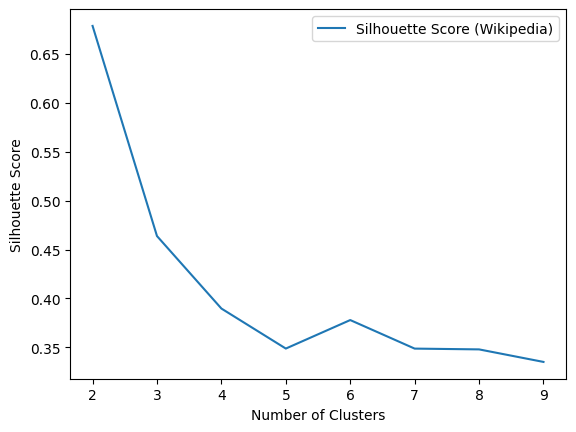

In [14]:
plt.plot(n, silhouette_scores_wiki, label="Silhouette Score (Wikipedia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

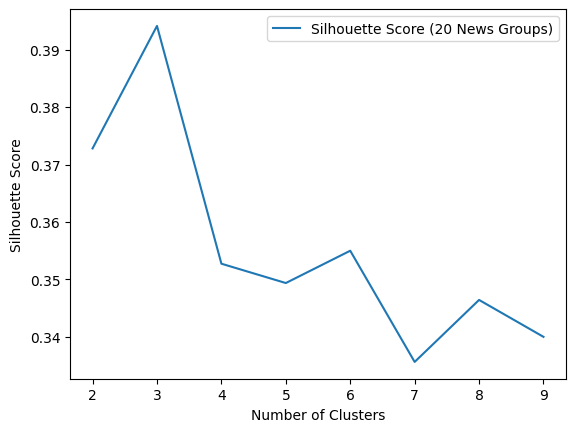

In [15]:
plt.plot(n, silhouette_scores_news, label="Silhouette Score (20 News Groups)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [27]:
M = 3
kmeans = KMeans(n_clusters=M, random_state=1234)
wiki_clusters = kmeans.fit_predict(wiki_pca)

In [17]:
print("Silhouette Score (wikidataset):", silhouette_score(wiki_pca,wiki_clusters))

Silhouette Score (wikidataset): 0.6788334750265573


In [18]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=1234)
newsgroups_clusters = kmeans.fit_predict(news_pca)

In [19]:
print("Silhouette Score (Newsgroups):", silhouette_score(news_pca,newsgroups_clusters))

Silhouette Score (Newsgroups): 0.3941474700241597


In [20]:
def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((np.max(y_pred) + 1, np.max(y_true) + 1))
    for i in range(len(y_pred)):
        contingency_matrix[y_pred[i], y_true[i]] += 1
    dominant_classes = np.max(contingency_matrix, axis=1)
    purity = np.sum(dominant_classes) / np.sum(contingency_matrix)
    return purity

In [22]:
purity = purity_score(labels, newsgroups_clusters)
print(f"Purity Score (news group) :{purity}")

Purity Score (news group) :0.1030988008065372


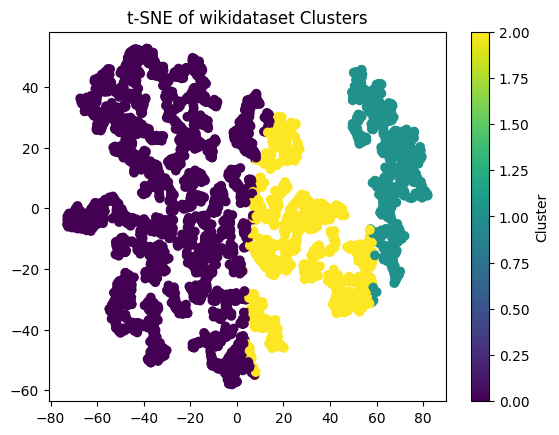

In [28]:
tsne = TSNE(n_components=2, random_state=1234)
wiki_tsne = tsne.fit_transform(wiki_pca)

plt.scatter(wiki_tsne[:, 0], wiki_tsne[:, 1], c=wiki_clusters, cmap='viridis')
plt.colorbar(label='Cluster')
plt.title("t-SNE of wikidataset Clusters")
plt.show()

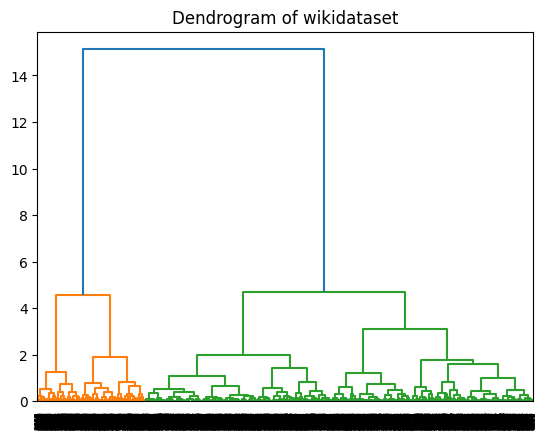

In [24]:
linkage_matrix = linkage(wiki_pca, method="ward")
dendrogram(linkage_matrix)
plt.title("Dendrogram of wikidataset")
plt.show()

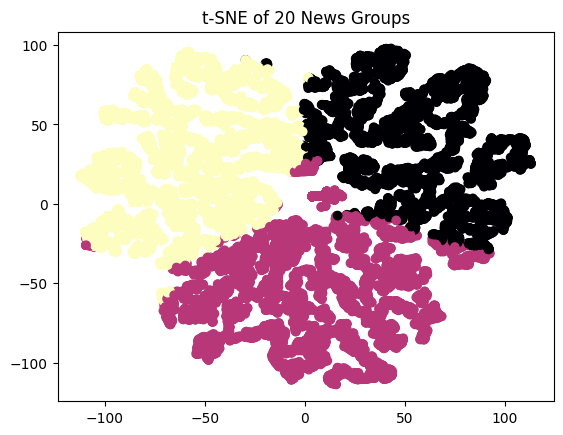

In [25]:
tsne = TSNE(n_components=2, random_state=1234)
news_tsne = tsne.fit_transform(news_pca)

plt.scatter(news_tsne[:, 0], news_tsne[:, 1], c=newsgroups_clusters, cmap='magma')
plt.title("t-SNE of 20 News Groups")
plt.show()

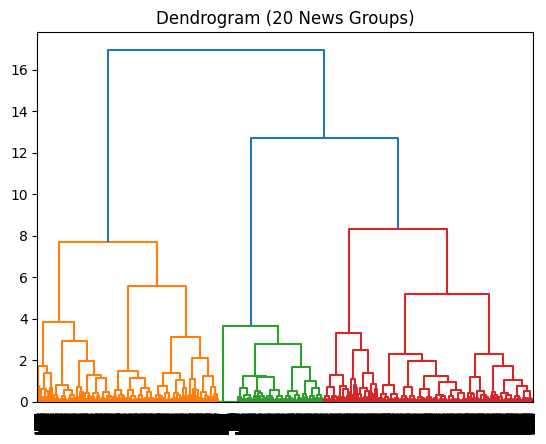

In [26]:
linkage_matrix = linkage(news_pca, method="ward")
dendrogram(linkage_matrix)
plt.title("Dendrogram (20 News Groups)")
plt.show()